<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=176529501" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
!pip install fastkaggle
!pip install optuna
!pip install optuna_distributed

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00


In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

import optuna

In [4]:
!ls /kaggle/input/playground-series-s4e5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test.csv  train.csv


In [ ]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [7]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [8]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [11]:
train_df.shape,original_df.shape

((1167957, 21), (50000, 21))

In [9]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape

(1167957, 21)

In [12]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')

In [13]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [14]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [15]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [16]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Neural Network Baseline

SuggestedLRs(slide=0.009120108559727669, valley=0.0005754399462603033)

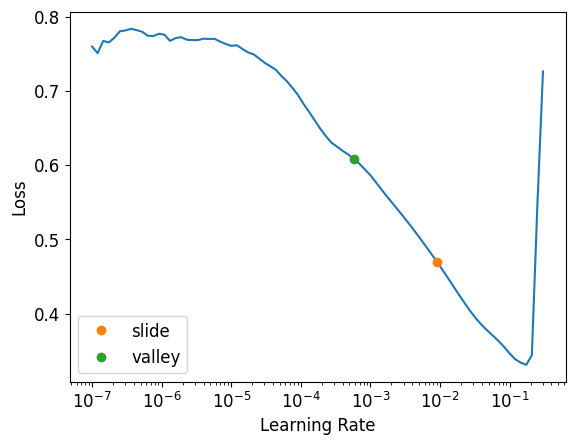

In [17]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [61]:
%%time
learn.fit_one_cycle(10,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000485,0.000434,0.833338,04:53
1,0.000542,0.000418,0.839743,04:49
2,0.000517,0.000420,0.838975,04:43
3,0.000559,0.000437,0.832341,04:45
4,0.000523,0.000469,0.820106,04:41
5,0.000542,0.000497,0.809464,04:45
6,0.000487,0.000420,0.838998,04:45
7,0.000484,0.000415,0.840621,04:42
8,0.000424,0.000389,0.850636,04:42
9,0.000439,0.000386,0.851999,04:41


CPU times: user 1h 34min 12s, sys: 18.5 s, total: 1h 34min 31s
Wall time: 47min 29s


In [62]:
dl = learn.dls.test_dl(test_df)

In [63]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 7min 44s, sys: 1.23 s, total: 7min 45s
Wall time: 3min 54s


In [64]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


catboost_info  fp_model.pkl  models  submission.csv


In [21]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [65]:
r2_score(y_test,nn_preds_x)

0.8519993237262152

In [41]:
r2_score(y_test,nn_preds_x)

0.8550518897187577

In [24]:
target_preds = nn_preds[0]

In [25]:
test_df['FloodProbability'] = target_preds

In [26]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [27]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,FloodProbability
0,1117957,0.573140
1,1117958,0.453772
2,1117959,0.453357
3,1117960,0.464622
4,1117961,0.465249


In [29]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
!ls

# CatBoost Baseline

In [ ]:
def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

# Create a study
study_catboost = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_catboost = optuna_distributed.from_study(study_catboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_catboost.optimize(objective_catboost, n_trials=40, n_jobs=num_parallel_jobs)

print(study_catboost.best_params)

In [43]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

[I 2024-05-08 17:42:04,960] A new study created in memory with name: no-name-4676c310-1db9-4fc2-827e-ebc389fb1566
[I 2024-05-08 17:42:34,702] Trial 0 finished with value: 0.03215043510245607 and parameters: {'learning_rate': 0.01768895341952706, 'depth': 8, 'random_strength': 8}. Best is trial 0 with value: 0.03215043510245607.
[I 2024-05-08 17:42:50,245] Trial 1 finished with value: 0.022578923672200837 and parameters: {'learning_rate': 0.1325284168693795, 'depth': 3, 'random_strength': 7}. Best is trial 1 with value: 0.022578923672200837.
[I 2024-05-08 17:43:19,238] Trial 2 finished with value: 0.029759591906668062 and parameters: {'learning_rate': 0.022399694152837702, 'depth': 8, 'random_strength': 9}. Best is trial 1 with value: 0.022578923672200837.
[I 2024-05-08 17:43:40,002] Trial 3 finished with value: 0.020364262822405454 and parameters: {'learning_rate': 0.11852094380370713, 'depth': 6, 'random_strength': 5}. Best is trial 3 with value: 0.020364262822405454.
[I 2024-05-08 17

{'learning_rate': 0.29776650862748444, 'depth': 9, 'random_strength': 3}


In [46]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=9, learning_rate= 0.29776650862748444, random_strength=3)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8508502177305014

In [30]:
#without optuna params
cat_model = CatBoostRegressor(iterations=500, depth=10, learning_rate= 0.08, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8497849381599005

# Light GBM

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)


In [44]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

[I 2024-05-08 18:45:29,431] A new study created in memory with name: no-name-bbf13ecf-6932-4899-95f7-c14a8055a3e2


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:46:07,205] Trial 0 finished with value: 0.022216366835694275 and parameters: {'num_leaves': 35, 'learning_rate': 0.0636400244864595, 'n_estimators': 200}. Best is trial 0 with value: 0.022216366835694275.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:46:36,095] Trial 1 finished with value: 0.03530875442830606 and parameters: {'num_leaves': 24, 'learning_rate': 0.025974734066045564, 'n_estimators': 156}. Best is trial 0 with value: 0.022216366835694275.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:46:56,959] Trial 2 finished with value: 0.021233515295115378 and parameters: {'num_leaves': 49, 'learning_rate': 0.14416347886142988, 'n_estimators': 115}. Best is trial 2 with value: 0.021233515295115378.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:47:28,334] Trial 3 finished with value: 0.021222144137371418 and parameters: {'num_leaves': 49, 'learning_rate': 0.08515872386244602, 'n_estimators': 174}. Best is trial 3 with value: 0.021222144137371418.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:47:50,026] Trial 4 finished with value: 0.02140309420963228 and parameters: {'num_leaves': 49, 'learning_rate': 0.12733886407274667, 'n_estimators': 117}. Best is trial 3 with value: 0.021222144137371418.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:48:09,580] Trial 5 finished with value: 0.02806667623088059 and parameters: {'num_leaves': 50, 'learning_rate': 0.06077212755768868, 'n_estimators': 100}. Best is trial 3 with value: 0.021222144137371418.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:48:34,069] Trial 6 finished with value: 0.02123631447194069 and parameters: {'num_leaves': 47, 'learning_rate': 0.20699764591483164, 'n_estimators': 175}. Best is trial 3 with value: 0.021222144137371418.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:49:12,025] Trial 7 finished with value: 0.028181466701508055 and parameters: {'num_leaves': 38, 'learning_rate': 0.033212866398653076, 'n_estimators': 196}. Best is trial 3 with value: 0.021222144137371418.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:49:43,625] Trial 8 finished with value: 0.020995284799478892 and parameters: {'num_leaves': 44, 'learning_rate': 0.17859213272862978, 'n_estimators': 180}. Best is trial 8 with value: 0.020995284799478892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.244548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:50:15,877] Trial 9 finished with value: 0.04232938644978339 and parameters: {'num_leaves': 41, 'learning_rate': 0.011070266303811239, 'n_estimators': 144}. Best is trial 8 with value: 0.020995284799478892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.259534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:50:38,724] Trial 10 finished with value: 0.021468477990886782 and parameters: {'num_leaves': 29, 'learning_rate': 0.28403266242997427, 'n_estimators': 175}. Best is trial 8 with value: 0.020995284799478892.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:51:14,023] Trial 11 finished with value: 0.02089347666583302 and parameters: {'num_leaves': 42, 'learning_rate': 0.10285423909419207, 'n_estimators': 176}. Best is trial 11 with value: 0.02089347666583302.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:51:44,839] Trial 12 finished with value: 0.020890916257698525 and parameters: {'num_leaves': 43, 'learning_rate': 0.12015566099107587, 'n_estimators': 157}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:52:09,953] Trial 13 finished with value: 0.02141160646272519 and parameters: {'num_leaves': 34, 'learning_rate': 0.10440807667637056, 'n_estimators': 150}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:52:35,961] Trial 14 finished with value: 0.032164747651574836 and parameters: {'num_leaves': 41, 'learning_rate': 0.032474141299282784, 'n_estimators': 140}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:53:04,455] Trial 15 finished with value: 0.021325555057770708 and parameters: {'num_leaves': 44, 'learning_rate': 0.09079695459029855, 'n_estimators': 162}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:53:22,394] Trial 16 finished with value: 0.02161884372907097 and parameters: {'num_leaves': 31, 'learning_rate': 0.2949025467087315, 'n_estimators': 134}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:53:51,511] Trial 17 finished with value: 0.026717105921684442 and parameters: {'num_leaves': 39, 'learning_rate': 0.04501262359358996, 'n_estimators': 163}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:54:27,802] Trial 18 finished with value: 0.034479597332558884 and parameters: {'num_leaves': 44, 'learning_rate': 0.01906960569560845, 'n_estimators': 191}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:54:58,838] Trial 19 finished with value: 0.02152637756386614 and parameters: {'num_leaves': 38, 'learning_rate': 0.07828691808845226, 'n_estimators': 184}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:55:23,361] Trial 20 finished with value: 0.020998064101158634 and parameters: {'num_leaves': 32, 'learning_rate': 0.18990264954370917, 'n_estimators': 165}. Best is trial 12 with value: 0.020890916257698525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:55:52,970] Trial 21 finished with value: 0.020857983720294525 and parameters: {'num_leaves': 45, 'learning_rate': 0.1566795738725457, 'n_estimators': 183}. Best is trial 21 with value: 0.020857983720294525.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:56:24,794] Trial 22 finished with value: 0.020749942290897917 and parameters: {'num_leaves': 46, 'learning_rate': 0.13088492438703078, 'n_estimators': 188}. Best is trial 22 with value: 0.020749942290897917.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:56:56,134] Trial 23 finished with value: 0.020803948889634785 and parameters: {'num_leaves': 45, 'learning_rate': 0.1398654927649905, 'n_estimators': 189}. Best is trial 22 with value: 0.020749942290897917.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:57:26,415] Trial 24 finished with value: 0.02089277431888173 and parameters: {'num_leaves': 46, 'learning_rate': 0.15747197626595527, 'n_estimators': 188}. Best is trial 22 with value: 0.020749942290897917.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:57:51,443] Trial 25 finished with value: 0.021304547920348676 and parameters: {'num_leaves': 46, 'learning_rate': 0.23191142383624647, 'n_estimators': 193}. Best is trial 22 with value: 0.020749942290897917.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:58:22,590] Trial 26 finished with value: 0.02079700967580945 and parameters: {'num_leaves': 47, 'learning_rate': 0.14316654360268802, 'n_estimators': 186}. Best is trial 22 with value: 0.020749942290897917.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:58:47,089] Trial 27 finished with value: 0.023854272259450558 and parameters: {'num_leaves': 20, 'learning_rate': 0.0726572724668407, 'n_estimators': 167}. Best is trial 22 with value: 0.020749942290897917.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:59:21,352] Trial 28 finished with value: 0.02067463313473177 and parameters: {'num_leaves': 47, 'learning_rate': 0.12004101991019928, 'n_estimators': 199}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 18:59:47,427] Trial 29 finished with value: 0.02127470659025018 and parameters: {'num_leaves': 48, 'learning_rate': 0.2249644988331908, 'n_estimators': 199}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:00:22,837] Trial 30 finished with value: 0.023966473650586947 and parameters: {'num_leaves': 36, 'learning_rate': 0.04966789341740122, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.453978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:00:58,822] Trial 31 finished with value: 0.02074585337357016 and parameters: {'num_leaves': 47, 'learning_rate': 0.11938211368775507, 'n_estimators': 187}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:01:31,810] Trial 32 finished with value: 0.020754527802599933 and parameters: {'num_leaves': 47, 'learning_rate': 0.10646235337589859, 'n_estimators': 185}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:02:06,777] Trial 33 finished with value: 0.02069265082774473 and parameters: {'num_leaves': 50, 'learning_rate': 0.10295614166019752, 'n_estimators': 193}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:02:42,273] Trial 34 finished with value: 0.021559951034935413 and parameters: {'num_leaves': 50, 'learning_rate': 0.06804401956639836, 'n_estimators': 194}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:03:13,216] Trial 35 finished with value: 0.02124345595033898 and parameters: {'num_leaves': 50, 'learning_rate': 0.08660993597446347, 'n_estimators': 169}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:03:47,786] Trial 36 finished with value: 0.02070646257668882 and parameters: {'num_leaves': 48, 'learning_rate': 0.11989911124186008, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:04:22,691] Trial 37 finished with value: 0.022803976093105142 and parameters: {'num_leaves': 40, 'learning_rate': 0.0564478358865575, 'n_estimators': 198}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:04:54,998] Trial 38 finished with value: 0.020771223760646166 and parameters: {'num_leaves': 48, 'learning_rate': 0.11271965226934642, 'n_estimators': 180}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:05:15,989] Trial 39 finished with value: 0.023717688119624037 and parameters: {'num_leaves': 27, 'learning_rate': 0.08676828506770991, 'n_estimators': 129}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:05:53,434] Trial 40 finished with value: 0.025169524834494045 and parameters: {'num_leaves': 49, 'learning_rate': 0.04103566779624313, 'n_estimators': 195}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:06:23,094] Trial 41 finished with value: 0.02097146286522861 and parameters: {'num_leaves': 48, 'learning_rate': 0.1713352451507202, 'n_estimators': 191}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:06:58,099] Trial 42 finished with value: 0.02071648963088573 and parameters: {'num_leaves': 50, 'learning_rate': 0.1260572948043887, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:07:33,953] Trial 43 finished with value: 0.02071328711708446 and parameters: {'num_leaves': 50, 'learning_rate': 0.09646835612089205, 'n_estimators': 199}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:08:10,842] Trial 44 finished with value: 0.02165644194142841 and parameters: {'num_leaves': 50, 'learning_rate': 0.06404036367504551, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:08:45,484] Trial 45 finished with value: 0.0207501507265077 and parameters: {'num_leaves': 49, 'learning_rate': 0.09493581243243125, 'n_estimators': 195}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:09:15,785] Trial 46 finished with value: 0.020805112631867975 and parameters: {'num_leaves': 50, 'learning_rate': 0.12713032636312532, 'n_estimators': 172}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:09:47,320] Trial 47 finished with value: 0.021473047893994145 and parameters: {'num_leaves': 43, 'learning_rate': 0.07909181897331183, 'n_estimators': 178}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:10:08,144] Trial 48 finished with value: 0.021330231829190256 and parameters: {'num_leaves': 48, 'learning_rate': 0.21047581920154618, 'n_estimators': 121}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:10:32,392] Trial 49 finished with value: 0.021410601007749337 and parameters: {'num_leaves': 45, 'learning_rate': 0.25444971811296624, 'n_estimators': 195}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:11:08,642] Trial 50 finished with value: 0.04128256034925911 and parameters: {'num_leaves': 42, 'learning_rate': 0.010027618761627565, 'n_estimators': 181}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:11:43,446] Trial 51 finished with value: 0.020693498926619876 and parameters: {'num_leaves': 47, 'learning_rate': 0.11593376898058502, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:12:17,457] Trial 52 finished with value: 0.02071593678294942 and parameters: {'num_leaves': 48, 'learning_rate': 0.10122016707039132, 'n_estimators': 192}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:12:36,913] Trial 53 finished with value: 0.02306257719500662 and parameters: {'num_leaves': 48, 'learning_rate': 0.09912892118721932, 'n_estimators': 105}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:13:05,837] Trial 54 finished with value: 0.02092761255358664 and parameters: {'num_leaves': 46, 'learning_rate': 0.1693376002090347, 'n_estimators': 192}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:13:39,721] Trial 55 finished with value: 0.020743937776475017 and parameters: {'num_leaves': 43, 'learning_rate': 0.1001246544335083, 'n_estimators': 196}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:14:14,112] Trial 56 finished with value: 0.021207208368992182 and parameters: {'num_leaves': 49, 'learning_rate': 0.0763643951064211, 'n_estimators': 191}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:14:40,961] Trial 57 finished with value: 0.02106841748168969 and parameters: {'num_leaves': 44, 'learning_rate': 0.11215754693591391, 'n_estimators': 152}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:15:11,782] Trial 58 finished with value: 0.02081625723854455 and parameters: {'num_leaves': 47, 'learning_rate': 0.14977134405878828, 'n_estimators': 184}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:15:49,436] Trial 59 finished with value: 0.03316156737938884 and parameters: {'num_leaves': 45, 'learning_rate': 0.02067032780614252, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:16:21,187] Trial 60 finished with value: 0.02260375593572956 and parameters: {'num_leaves': 49, 'learning_rate': 0.06328161429210222, 'n_estimators': 172}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:16:55,074] Trial 61 finished with value: 0.020756786593740365 and parameters: {'num_leaves': 50, 'learning_rate': 0.1329932515716508, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:17:22,301] Trial 62 finished with value: 0.021081479312219858 and parameters: {'num_leaves': 47, 'learning_rate': 0.18923324176347844, 'n_estimators': 190}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:17:56,615] Trial 63 finished with value: 0.020700108867149493 and parameters: {'num_leaves': 49, 'learning_rate': 0.12014917542327659, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:18:30,747] Trial 64 finished with value: 0.020867225799721483 and parameters: {'num_leaves': 46, 'learning_rate': 0.0892662468099933, 'n_estimators': 193}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:19:03,796] Trial 65 finished with value: 0.02073475951302726 and parameters: {'num_leaves': 48, 'learning_rate': 0.1183200045892609, 'n_estimators': 188}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.226553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:19:39,242] Trial 66 finished with value: 0.02070439351505224 and parameters: {'num_leaves': 49, 'learning_rate': 0.10571945139169081, 'n_estimators': 198}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:20:11,916] Trial 67 finished with value: 0.020770088735259373 and parameters: {'num_leaves': 49, 'learning_rate': 0.1447025041140858, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:20:42,126] Trial 68 finished with value: 0.02088423604648259 and parameters: {'num_leaves': 44, 'learning_rate': 0.16490281762265235, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:21:14,045] Trial 69 finished with value: 0.02078451296043129 and parameters: {'num_leaves': 46, 'learning_rate': 0.10847736894005197, 'n_estimators': 182}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:21:44,083] Trial 70 finished with value: 0.020719289030127156 and parameters: {'num_leaves': 36, 'learning_rate': 0.13566702584966606, 'n_estimators': 186}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.269222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:22:18,750] Trial 71 finished with value: 0.020794056307458262 and parameters: {'num_leaves': 49, 'learning_rate': 0.0945937200121135, 'n_estimators': 193}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:22:52,662] Trial 72 finished with value: 0.02104267999467486 and parameters: {'num_leaves': 47, 'learning_rate': 0.08222204934966977, 'n_estimators': 190}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:23:28,117] Trial 73 finished with value: 0.021471411413268124 and parameters: {'num_leaves': 48, 'learning_rate': 0.06906694981450115, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:24:02,604] Trial 74 finished with value: 0.02070976700574646 and parameters: {'num_leaves': 50, 'learning_rate': 0.10296980899583413, 'n_estimators': 193}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:24:36,843] Trial 75 finished with value: 0.02069151889288518 and parameters: {'num_leaves': 49, 'learning_rate': 0.11622264792208192, 'n_estimators': 194}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:24:58,319] Trial 76 finished with value: 0.0216820746330812 and parameters: {'num_leaves': 23, 'learning_rate': 0.11802800436266637, 'n_estimators': 141}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:25:28,583] Trial 77 finished with value: 0.020838880113824558 and parameters: {'num_leaves': 49, 'learning_rate': 0.15670418859150814, 'n_estimators': 188}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.262568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:25:55,840] Trial 78 finished with value: 0.021087295342141786 and parameters: {'num_leaves': 46, 'learning_rate': 0.19275628400247538, 'n_estimators': 195}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:26:26,485] Trial 79 finished with value: 0.02076477565900581 and parameters: {'num_leaves': 45, 'learning_rate': 0.12588394076317394, 'n_estimators': 179}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:26:58,869] Trial 80 finished with value: 0.02071968301670216 and parameters: {'num_leaves': 47, 'learning_rate': 0.10904267620409971, 'n_estimators': 185}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:27:34,444] Trial 81 finished with value: 0.020805854140077944 and parameters: {'num_leaves': 50, 'learning_rate': 0.08688808935207333, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:28:07,297] Trial 82 finished with value: 0.020784543397335927 and parameters: {'num_leaves': 50, 'learning_rate': 0.14093546355733422, 'n_estimators': 198}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:28:42,266] Trial 83 finished with value: 0.02124224412830002 and parameters: {'num_leaves': 49, 'learning_rate': 0.07442677602783505, 'n_estimators': 194}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:29:16,108] Trial 84 finished with value: 0.02081461626386402 and parameters: {'num_leaves': 50, 'learning_rate': 0.09338118554677574, 'n_estimators': 189}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:29:50,693] Trial 85 finished with value: 0.020686110291138152 and parameters: {'num_leaves': 48, 'learning_rate': 0.10527897373499029, 'n_estimators': 198}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:30:24,371] Trial 86 finished with value: 0.020700352146434488 and parameters: {'num_leaves': 48, 'learning_rate': 0.11868663763599265, 'n_estimators': 194}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:30:55,828] Trial 87 finished with value: 0.020682388367582093 and parameters: {'num_leaves': 33, 'learning_rate': 0.11896877949729956, 'n_estimators': 197}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:31:25,400] Trial 88 finished with value: 0.020788906346954412 and parameters: {'num_leaves': 31, 'learning_rate': 0.15160438872049864, 'n_estimators': 191}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:32:02,495] Trial 89 finished with value: 0.03884099821610325 and parameters: {'num_leaves': 33, 'learning_rate': 0.013182224340720701, 'n_estimators': 195}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.191235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:32:34,135] Trial 90 finished with value: 0.020680059642307028 and parameters: {'num_leaves': 34, 'learning_rate': 0.12990139031057166, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.214578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:33:05,357] Trial 91 finished with value: 0.020703566093114006 and parameters: {'num_leaves': 31, 'learning_rate': 0.1330406421710388, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:33:36,193] Trial 92 finished with value: 0.02067669094173632 and parameters: {'num_leaves': 29, 'learning_rate': 0.1311288862760473, 'n_estimators': 200}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:34:06,031] Trial 93 finished with value: 0.020711174574215795 and parameters: {'num_leaves': 27, 'learning_rate': 0.11654460344010993, 'n_estimators': 195}. Best is trial 28 with value: 0.02067463313473177.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:34:37,504] Trial 94 finished with value: 0.020667064181875396 and parameters: {'num_leaves': 34, 'learning_rate': 0.1282998099778596, 'n_estimators': 198}. Best is trial 94 with value: 0.020667064181875396.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:35:03,866] Trial 95 finished with value: 0.02088577616118408 and parameters: {'num_leaves': 35, 'learning_rate': 0.12707857534281725, 'n_estimators': 160}. Best is trial 94 with value: 0.020667064181875396.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.190279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:35:31,315] Trial 96 finished with value: 0.020897472593825562 and parameters: {'num_leaves': 33, 'learning_rate': 0.18140850701286218, 'n_estimators': 198}. Best is trial 94 with value: 0.020667064181875396.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:36:00,410] Trial 97 finished with value: 0.02079108871283696 and parameters: {'num_leaves': 29, 'learning_rate': 0.16205698154130888, 'n_estimators': 200}. Best is trial 94 with value: 0.020667064181875396.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:36:31,603] Trial 98 finished with value: 0.020784400855259354 and parameters: {'num_leaves': 37, 'learning_rate': 0.141205853643728, 'n_estimators': 191}. Best is trial 94 with value: 0.020667064181875396.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-08 19:37:02,808] Trial 99 finished with value: 0.021360684860082874 and parameters: {'num_leaves': 30, 'learning_rate': 0.08200596044772845, 'n_estimators': 196}. Best is trial 94 with value: 0.020667064181875396.


{'num_leaves': 34, 'learning_rate': 0.1282998099778596, 'n_estimators': 198}


In [47]:
lgb_model = lgb.LGBMRegressor(num_leaves=34, learning_rate=0.1282998099778596, n_estimators=198)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.8361207633995348

In [31]:
lgb_model = lgb.LGBMRegressor(num_leaves=47, learning_rate=0.19470589857022183, n_estimators=165)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.8289420933149213

# XGBoost

In [45]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)

[I 2024-05-08 19:37:02,829] A new study created in memory with name: no-name-ffe12cb2-29d9-47a6-a404-445c5102b28b
[I 2024-05-08 19:37:20,561] Trial 0 finished with value: 0.021343758329749107 and parameters: {'n_estimators': 176, 'max_depth': 5, 'learning_rate': 0.27308559052143444, 'subsample': 0.7894496370597744}. Best is trial 0 with value: 0.021343758329749107.
[I 2024-05-08 19:37:35,314] Trial 1 finished with value: 0.030077384784817696 and parameters: {'n_estimators': 128, 'max_depth': 4, 'learning_rate': 0.06667131469377875, 'subsample': 0.631565489994721}. Best is trial 0 with value: 0.021343758329749107.
[I 2024-05-08 19:38:02,201] Trial 2 finished with value: 0.036746107041835785 and parameters: {'n_estimators': 163, 'max_depth': 6, 'learning_rate': 0.017316193973622957, 'subsample': 0.27453922283558374}. Best is trial 0 with value: 0.021343758329749107.
[I 2024-05-08 19:38:14,508] Trial 3 finished with value: 0.030679412186145782 and parameters: {'n_estimators': 128, 'max_de

{'n_estimators': 196, 'max_depth': 5, 'learning_rate': 0.1461774202844157, 'subsample': 0.6649609199174655}


In [48]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8330894373473128

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')
study_xgboost = optuna_distributed.from_study(study_xgboost)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
study_xgboost.optimize(objective_xgboost, n_trials=30)
print(study_xgboost.best_params)

In [32]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.08, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.8275227894086742

# General Ensemble

In [51]:
nn_preds_m = nn_preds_x.squeeze()

In [52]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

tensor([0.5030, 0.4892, 0.4985,  ..., 0.5667, 0.5888, 0.4134])

In [54]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

tensor([0.5058, 0.4884, 0.4997,  ..., 0.5685, 0.5902, 0.4055])

In [55]:
r2_score(y_test,general_preds)

0.8542809434836184

In [53]:
r2_score(y_test,general_preds)

0.8507983179178428

In [37]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


catboost_info  fp_model.pkl  models


In [ ]:
general_preds.shape

In [56]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

tensor([0.5717, 0.4552, 0.4542,  ..., 0.6213, 0.5530, 0.5111])

# Scoring

In [59]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [60]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


catboost_info  fp_model.pkl  models  submission.csv


In [ ]:
!rm submission.csv